<span style="color:gray">
Copyright &copy; 2020-2021 by Fraunhofer-Gesellschaft. All rights reserved.<br>
Fraunhofer Institute for Integrated Circuits IIS, Division Engineering of Adaptive Systems EAS<br>
Zeunerstraße 38, 01069 Dresden, Germany
</span>

---

## ESB - Energy Saving by Blockchain

Eurostars – EXP 00119832 / EUS-2019113348

---

## Prediction of Energy Consumption for Variable Customer Portfolios Including Aleatoric Uncertainty Estimation

*Oliver Mey, André Schneider, Olaf Enge-Rosenblatt, Yesnier Bravo, Pit Stenzel*

The notebook is part of a paper submission contributed to the **10th International Conference on Power Science and Engineering (ICPSE 2021)** will be held on Oct. 21-23, 2021 in Yildiz Technical University, Istanbul, Turkey.

---

# B2: Data Preprocessing and Feature Extraction

This notebook loads the available datasets, splits the datasets into three subsets for training, test and validation, fits the scalers and encoders for feature extraction, and extracts the features for all subsets. At the end, the feature vectors are explained in detail.

---

<span style="color:gray">
Version 0.4.3 (August 5, 2021)<br>
Authors: Oliver Mey, André Schneider (Fraunhofer IIS)<br>
</span>    

In [17]:
import warnings
warnings.filterwarnings('ignore')

import os
import joblib
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import holidays as hd
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow.keras.models import load_model
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler

%matplotlib inline
sns.set(rc={'figure.figsize':(16, 6)})

### Configuration

In [31]:
path = '..'
timezone = 'Europe/Madrid'
date = '2019-02-02'
customer = 20
seed = 12345

properties = {
    't_consumption_daily':  [-14, -1],
    't_weather_daily':      [-14, -1],
    't_consumption_hourly':  [-7, -1],
    't_weather_hourly':      [-2,  0],
}

### Function Definitions

In [246]:
def fix_DST(data):
    data = data[~data.index.duplicated(keep='first')]
    data = data.resample('H').ffill()
    return data

def crop(data):
    hour_index = data.index.hour
    t0 = data[hour_index==0].head(1).index
    tn = data[hour_index==23].tail(1).index
    data.drop(data.loc[data.index < t0[0]].index, inplace=True)
    data.drop(data.loc[data.index > tn[0]].index, inplace=True)
    return

def time_from_to(date, t, tz=timezone):
    t0_ = pd.Timestamp(date, tz=tz)+pd.Timedelta(days=t[0])
    tn_ = pd.Timestamp(date, tz=tz)+pd.Timedelta(days=t[1])+pd.Timedelta(hours=23)
    return slice(t0_, tn_)

def day_from_to(date, t, tz=timezone):
    t0_ = pd.Timestamp(date)+pd.Timedelta(days=t[0])
    tn_ = pd.Timestamp(date)+pd.Timedelta(days=t[1])
    return slice(t0_, tn_)

def softrange(x, x_min=0, x_max=1):
    r = x_max - x_min
    y = x_min + tf.constant(r)/tf.math.softplus(r) * tf.math.softplus(-tf.math.softplus(x_max-x) + r)
    return y

### Class Definitions

#### Data Loader

In [269]:
class DataLoader:
    
    def __init__(self, data_path, model_path):
        self.data_path = data_path
        self.model_path = model_path
        self.categories = ['consumption', 'weather', 'profiles']
        self.scaler_names = ['scaler_consumptions', 'scaler_consumptions_daily_mean',
                             'scaler_weather_daily_mean', 'scaler_day_of_month', 'scaler_month',
                             'scaler_weather_forecast']
        self.files = [self.data_path + '/' + '20201015_' + name + '.xlsx' for name in self.categories]
        return
    
    def scale_data(self, data):
        x = data.groupby(data.index.date).mean()
        x.index = pd.to_datetime(x.index)
        x = x.append(pd.DataFrame(x.tail(1), index=x.tail(1).index+pd.Timedelta(days=1)))
        x = x.resample('h').ffill()[:-1]
        x.index = data.index
        y = data / x
        y.fillna(value=0, inplace=True)
        return y
    
    def load_metadata(self):
        customers = pd.read_excel(self.files[self.categories.index('profiles')])
        customers.columns = ['customer', 'profile']
        profiles = pd.DataFrame(customers['profile'].unique(), columns=['profile'])
        holidays = hd.ES(years=list(range(2010, 2021)), prov="MD")
        return customers, profiles, holidays
    
    def load_data(self):
        consumptions = pd.read_excel(self.files[self.categories.index('consumption')], 
                                     parse_dates=[0], index_col=0)
        consumptions.columns = pd.DataFrame(consumptions.columns, columns=['customer']).index
        consumptions.index.name = 'time'
        consumptions = fix_DST(consumptions)
        consumptions_scaled = self.scale_data(consumptions)
        weather = pd.read_excel(self.files[self.categories.index('weather')], parse_dates=[0], index_col=0)
        weather.columns = consumptions.columns
        weather.index.name = 'time'
        weather = fix_DST(weather)
        weather_forecast = weather.copy()
        weather_forecast.index = weather.index-pd.Timedelta(days=1)
        weather_forecast = fix_DST(weather_forecast)
        return consumptions, consumptions_scaled, weather, weather_forecast
    
    def load_scalers(self):
        scalers = [joblib.load(self.model_path + '/' + name) for name in self.scaler_names]
        scalers = dict(zip(self.scaler_names, scalers))
        scale = scalers['scaler_consumptions'].scale_
        offset = scalers['scaler_consumptions'].mean_
        return scalers
    
    def load_models(self, names):
        models = [load_model(model_path + '/' + name + '.h5') for name in names]
        models = dict(zip(names, models))
        return models

#### Feature Extractor

In [197]:
class FeatureExtractor:
    
    def __init__(self, properties, refit=False):
        self.t_consumption_daily = properties.get('t_consumption_daily', [-13, -1])
        self.t_consumption_hourly = properties.get('t_consumption_hourly', [-2, -1])
        self.t_weather_daily = properties.get('t_weather_daily', [-2, -0])
        self.t_weather_hourly = properties.get('t_weather_hourly', [-2, -0])
        self.encoder = properties.get('encoder')
        
        if not refit:
            scalers = properties.get('scalers')
            self.scaler_consumption = scalers['scaler_consumptions']
            self.scaler_weather = scalers['scaler_weather']
            self.scaler_weather_forecast = scalers['scaler_weather_forecast']
            self.scaler_day_of_month = scalers['scaler_day_of_month']
            self.scaler_month = scalers['scaler_month']      
        return

    def get_days(self, dates, holidays):
        days = pd.DataFrame(pd.to_datetime(dates.date), index=dates, columns=['date'])
        days['day_of_week'] = list(days.index.dayofweek)
        days['day_of_month'] = list(days.index.day)
        days['month'] = list(days.index.month)
        days['day_category'] = days['day_of_week'].replace({0:0,1:1,2:1,3:1,4:2,5:3,6:4})
        days.loc[days['date'].apply(lambda d: d in holidays), 'day_category'] = 4
        days = days.groupby(['date']).first()
        return days
        
    def split(self, indices, seed=12345):
        n = len(indices)
        n_validate = n//10
        n_test = n//10
        n_train = n-n_validate - n_test
        np.random.seed(seed)
        I = np.random.permutation(indices)
        I_train = I[0:n_train]
        I_test = I[n_train:n_train + n_test]
        I_validate = I[n_train + n_test:]
        return I_train, I_test, I_validate

    def fit(self, consumptions, weather, weather_forecast, holidays):
        days = self.get_days(consumptions.index, holidays)
        consumptions_daily_mean = pd.DataFrame(consumptions.groupby(consumptions.index.date).mean(), 
                                               index=days.index)
        weather_daily_mean = pd.DataFrame(weather.groupby(weather.index.date).mean(), index=days.index)
        households = customers[customers['profile'].astype(str).str.contains('hogares')].index.values
        I_train, I_test, I_validate = self.split(households, seed)
        self.scaler_consumptions = RobustScaler(quantile_range=(0,75))
        self.scaler_consumptions.fit(consumptions_daily_mean.loc[:, I_train].values.reshape(-1, 1))
        self.scaler_weather = RobustScaler(quantile_range=(0,75))
        self.scaler_weather.fit(weather_daily_mean.loc[:, I_train].values.reshape(-1, 1))
        self.scaler_day_of_month = RobustScaler(quantile_range=(0,75))
        self.scaler_day_of_month.fit(days['day_of_month'].values.reshape(-1, 1))
        self.scaler_month = RobustScaler(quantile_range=(0,75))
        self.scaler_month.fit(days['month'].values.reshape(-1, 1))
        X = weather_forecast.loc[:, I_train]
        X.index = pd.MultiIndex.from_arrays([X.index.date, X.index.time], names=['date','time'])
        X = X.stack().unstack(level=1)
        self.scaler_weather_forecast = RobustScaler(quantile_range=(0,75))
        self.scaler_weather_forecast.fit(X)
        scalers = self.get_scalers()
        dates = consumptions_daily_mean.index.date
        
        self.days = days
        self.consumptions_daily_mean = consumptions_daily_mean
        self.weather_daily_mean = weather_daily_mean
        
        return [I_train, I_test, I_validate], dates, scalers
    
    def get_scalers(self):
        scalers = {'scaler_consumptions': self.scaler_consumptions,
                   'scaler_weather': self.scaler_weather,
                   'scaler_weather_forecast': self.scaler_weather_forecast,
                   'scaler_day_of_month': self.scaler_day_of_month,
                   'scaler_month': self.scaler_month
                  }
        return scalers
            
        
    def extract(self, date, customer, consumptions, weather, holidays, offset=1e-5):
        days = self.days
        consumptions_daily_mean = self.consumptions_daily_mean
        weather_daily_mean = self.weather_daily_mean
        X1 = consumptions.loc[time_from_to(date, self.t_consumption_hourly),customer].values
        X1 = np.array(X1).reshape(-1) + offset
        X2 = weather.loc[time_from_to(date, self.t_weather_hourly),customer].values
        X2 = self.scaler_weather_forecast.transform(np.array(X2).reshape(3,24)).reshape(-1)
        X2 = (X2+1)/2
        X3 = days.loc[pd.Timestamp(date),'month']
        X3 = self.scaler_month.transform(np.array([X3]).reshape(-1,1))[0][0]
        X3 = (X3+1)/2
        X4 = days.loc[pd.Timestamp(date),'day_of_month']
        X4 = self.scaler_day_of_month.transform(np.array([X4]).reshape(-1,1))[0][0]
        X4 = (X4+1)/2
        X5 = days.loc[pd.Timestamp(date),'day_category']
        X5 = self.encoder.transform(np.array(X5).reshape(1, -1)).reshape(-1)
        X6 = consumptions_daily_mean.loc[day_from_to(date, self.t_consumption_daily), customer].values
        X6 = X6/(2*self.scaler_consumptions.scale_) + offset
        X7 = weather_daily_mean.loc[day_from_to(date, self.t_weather_daily), customer].values
        X7 = self.scaler_weather.transform(np.array([X7]).reshape(-1,1)).reshape(-1)
        X7 = (X7+1)/2
        Xa = np.concatenate([X1, X2, [X3], [X4], X5]).reshape(1,-1)
        ya = consumptions.loc[time_from_to(date, [0, 0]),customer].values
        Xb = np.concatenate([X6, X7, X5, [X4], [X3]]).reshape(1,-1)
        yb = consumptions_daily_mean.loc[day_from_to(date, [0, 0]), customer].values
        return [Xa, ya, Xb, yb]

#### Prediction Model

In [210]:
class PredictionModel:
    
    def __init__(self, Xy, properties):
        scalers = properties.get('scalers')
        self.inputs = properties.get('inputs', [247, 35])
        self.scale = scalers['scaler_consumptions'].scale_
        self.offset = scalers['scaler_consumptions'].center_
        
        self.Xa_train, self.ya_train, self.Xb_train, self.yb_train = self.get_samples(Xy[0])
        self.Xa_test, self.ya_test, self.Xb_test, self.yb_test = self.get_samples(Xy[1])
        self.Xa_validate, self.ya_validate, self.Xb_validate, self.yb_validate = self.get_samples(Xy[2])
        return
    
    def get_samples(self, Xy):
        Xa = np.concatenate([Xy[i][0] for i in range(len(Xy))])
        ya = np.concatenate([Xy[i][1] for i in range(len(Xy))]).reshape(-1,24)
        Xb = np.concatenate([Xy[i][2] for i in range(len(Xy))])
        yb = np.concatenate([Xy[i][3] for i in range(len(Xy))]).reshape(-1,1)
        return Xa, ya, Xb, yb

### Loading Data

In [270]:
loader = DataLoader(path + '/data', path + '/models')
consumptions, consumptions_scaled, weather, weather_forecast = loader.load_data()
customers, profiles, holidays = loader.load_metadata()
scalers = loader.load_scalers()
encoder = OneHotEncoder(sparse=False)
encoder.fit(np.arange(5).reshape(-1,1))

OneHotEncoder(sparse=False)

In [272]:
properties['encoder'] = encoder

### Extracting Features

In [273]:
extractor = FeatureExtractor(properties, refit=True)

In [274]:
I, dates, scalers = extractor.fit(consumptions, weather, weather_forecast, holidays)

In [275]:
features = [[extractor.extract(date, customer, consumptions_scaled, weather, holidays)
       for date in dates[15:] for customer in Ii] for Ii in I]

### Preparing the Model

In [276]:
properties['scalers'] = scalers

In [277]:
model = PredictionModel(features, properties)

### Recorded and Preprocessed Data

#### Consumptions

The dataframe *consumptions* contains the recorded hourly energy consumptions in kWh (*rows*) for all 499 customers (*columns*).

In [278]:
consumptions

,0,1,2,3,4,5,6,7,8,9,...,489,490,491,492,493,494,495,496,497,498
time,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,0.039,0.384,0.986,0.706,0.304,0.073,3.262,3.0,0.645,1.279,...,0.431,0.100,0.010,0.258,0.009,0.488,0.810,0.309,0.366,0.290
2019-01-01 01:00:00,0.269,0.051,0.846,2.210,0.673,0.047,3.252,4.0,0.746,0.851,...,0.447,0.025,0.009,0.232,0.009,0.447,0.753,0.381,0.308,0.369
2019-01-01 02:00:00,0.331,0.049,0.970,1.797,0.310,0.058,3.043,4.0,0.678,0.789,...,0.439,0.025,0.009,0.260,0.009,0.508,0.092,0.193,0.137,0.292
2019-01-01 03:00:00,0.093,0.049,0.803,1.010,0.545,0.059,2.960,4.0,0.644,0.637,...,0.913,0.023,0.009,0.252,0.009,0.511,0.032,0.124,0.201,0.358
2019-01-01 04:00:00,0.116,0.050,1.303,0.660,0.410,0.072,3.054,3.0,0.130,0.262,...,1.256,0.024,0.009,0.278,0.009,0.510,0.081,0.081,0.223,0.380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,0.009,0.052,0.773,0.138,0.579,0.322,3.851,2.0,0.236,0.303,...,0.039,1.308,0.009,1.761,0.011,2.036,0.249,0.223,0.245,0.573
2019-12-31 20:00:00,0.009,0.410,0.738,0.076,0.229,1.810,3.767,1.0,0.053,5.062,...,0.036,0.298,0.027,0.375,0.011,2.022,0.058,0.363,0.354,0.644
2019-12-31 21:00:00,0.010,0.058,0.748,0.072,0.107,1.478,3.342,1.0,0.108,2.140,...,0.261,0.120,0.052,0.463,0.010,1.107,0.011,0.573,0.393,0.635


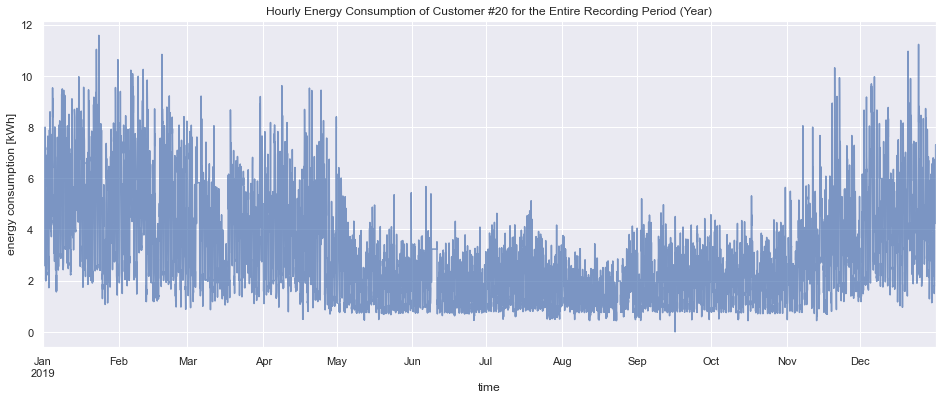

In [279]:
_ = consumptions.loc[:, customer].plot(title='Hourly Energy Consumption of Customer #' + \
                                   str(customer) + ' for the Entire Recording Period (Year)',
                                  ylabel='energy consumption [kWh]', color='b', alpha=0.7)

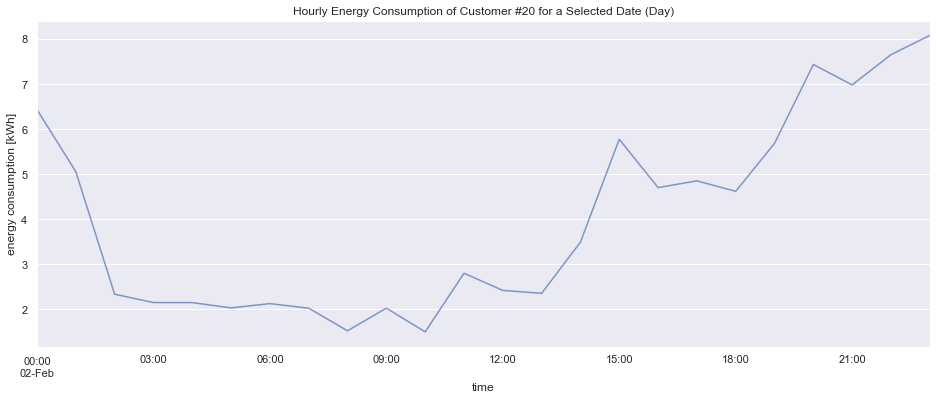

In [280]:
_ = consumptions.loc[date, customer].plot(title='Hourly Energy Consumption of Customer #' + \
                                   str(customer) + ' for a Selected Date (Day)',
                                  ylabel='energy consumption [kWh]', color='b', alpha=0.7)

The dataframe *consumptions_daily_mean* contains the daily mean energy consumption for all customers.

In [281]:
extractor.consumptions_daily_mean

,0,1,2,3,4,5,6,7,8,9,...,489,490,491,492,493,494,495,496,497,498
date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,0.107208,0.119875,0.932625,0.432833,0.580750,0.155292,3.258292,3.083333,0.310667,0.663500,...,0.484083,0.090833,0.017417,0.257833,0.008958,0.876458,0.107708,0.249500,0.280333,0.341458
2019-01-02,0.145333,0.112542,1.224708,0.394375,0.312583,0.201458,3.240833,3.125000,0.359667,1.056167,...,0.535167,0.207208,0.017833,1.256625,0.008792,1.031042,0.043375,0.256208,0.329125,0.364458
2019-01-03,0.453875,0.297750,1.159792,0.532375,0.418292,0.300583,3.323167,2.791667,0.331083,0.842958,...,0.588833,0.226792,0.018042,1.335750,0.008917,1.105083,0.041417,0.277292,0.325250,0.367042
2019-01-04,0.640625,0.288208,1.158750,0.387958,0.459500,0.205417,3.309583,2.875000,0.280542,1.194917,...,0.486542,0.215167,0.017917,1.038750,0.008875,1.100333,0.038833,0.317458,0.329500,0.371917
2019-01-05,0.482958,0.285708,1.099417,0.519792,0.191208,0.213208,3.298625,2.833333,0.221875,0.951708,...,0.376167,0.086333,0.017625,0.543000,0.363250,1.001625,0.038625,0.276875,0.325792,0.366250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,0.000000,0.114250,1.130208,0.275958,0.220958,0.129042,3.240458,2.859417,0.347042,0.844292,...,0.387542,0.271125,0.021042,1.155583,0.599708,0.865417,0.040750,0.292458,0.287458,0.511625
2019-12-28,0.000000,0.115958,1.087667,0.316417,0.478667,0.103792,3.336417,2.691667,0.261583,0.447042,...,0.349333,0.045125,0.020500,0.597792,1.556708,0.638792,0.038958,0.213125,0.235708,0.498042
2019-12-29,0.262000,0.116167,0.928208,0.262750,0.444292,0.148417,3.481667,2.900000,0.404083,0.786333,...,0.342167,0.045042,0.020583,0.402208,0.281792,0.736917,0.038917,0.210375,0.200708,0.500333


The dataframe *consumptions_scaled* contains the scaled energy consumptions for all customers. The raw values (see *consumptions*) are divided by the daily mean consumption (see *consumptions_daily_mean*) of the customer.

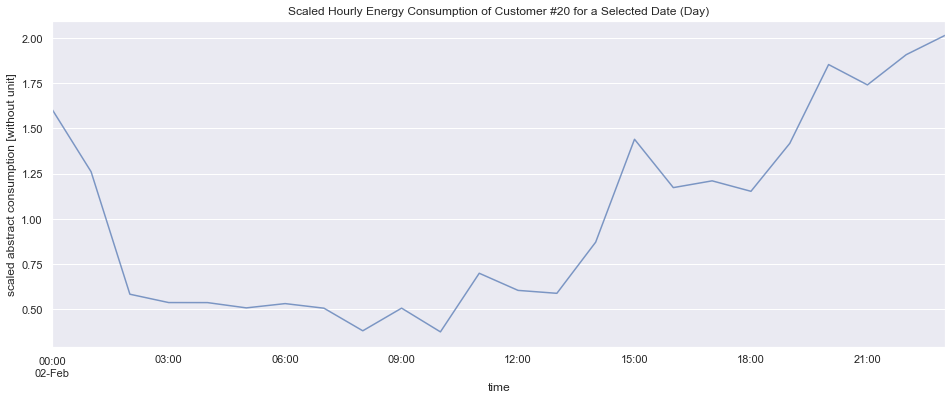

In [282]:
_ = consumptions_scaled.loc[date, customer].plot(title='Scaled Hourly Energy Consumption of Customer #' + \
                                   str(customer) + ' for a Selected Date (Day)',
                                  ylabel='scaled abstract consumption [without unit]', color='b', alpha=0.7)

The daily sum (total) of the scaled consumption values (see *consumptions_scaled*) is *24*.

#### Weather

The dataframe *weather* contains the weather data (outside temperature in °C) for the customers region with an hourly time resolution.

In [283]:
weather

,0,1,2,3,4,5,6,7,8,9,...,489,490,491,492,493,494,495,496,497,498
time,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,10.31,10.35,1.65,1.70,11.53,10.76,10.57,0.43,1.66,10.49,...,10.40,9.53,9.94,3.19,3.14,3.20,2.63,1.51,1.51,1.51
2019-01-01 01:00:00,10.34,10.38,1.33,1.37,11.78,10.79,10.61,0.17,1.33,10.73,...,10.65,10.21,10.63,3.70,3.65,3.71,2.08,1.21,1.21,1.21
2019-01-01 02:00:00,10.36,10.40,1.01,1.05,12.03,10.82,10.64,-0.09,1.01,10.98,...,10.90,10.88,11.33,4.22,4.17,4.23,1.53,0.91,0.91,0.91
2019-01-01 03:00:00,10.39,10.43,0.69,0.73,12.28,10.84,10.68,-0.34,0.69,11.23,...,11.14,11.56,12.02,4.74,4.69,4.75,0.99,0.60,0.60,0.60
2019-01-01 04:00:00,10.27,10.31,0.47,0.51,12.13,10.73,10.57,-0.62,0.48,11.06,...,10.97,11.33,11.79,4.47,4.42,4.48,0.76,0.38,0.38,0.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,17.99,18.03,14.88,14.94,17.51,18.15,18.08,12.33,14.89,16.91,...,16.84,16.00,16.10,11.62,11.57,11.63,8.99,13.20,13.20,13.20
2019-12-31 20:00:00,17.87,17.91,14.69,14.74,17.32,18.10,18.01,12.45,14.70,16.62,...,16.54,15.84,16.01,11.03,10.98,11.04,8.11,13.01,13.01,13.01
2019-12-31 21:00:00,17.74,17.78,14.50,14.55,17.14,18.05,17.94,12.57,14.50,16.33,...,16.25,15.68,15.93,10.44,10.39,10.45,7.22,12.82,12.82,12.82


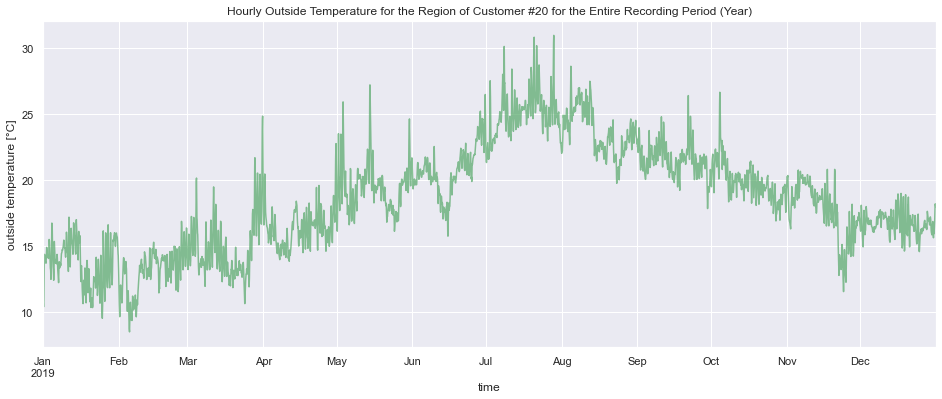

In [284]:
_ = weather.loc[:, customer].plot(title='Hourly Outside Temperature for the Region of Customer #' + \
                                   str(customer) + ' for the Entire Recording Period (Year)',
                                  ylabel='outside temperature [°C]', color='g', alpha=0.7)

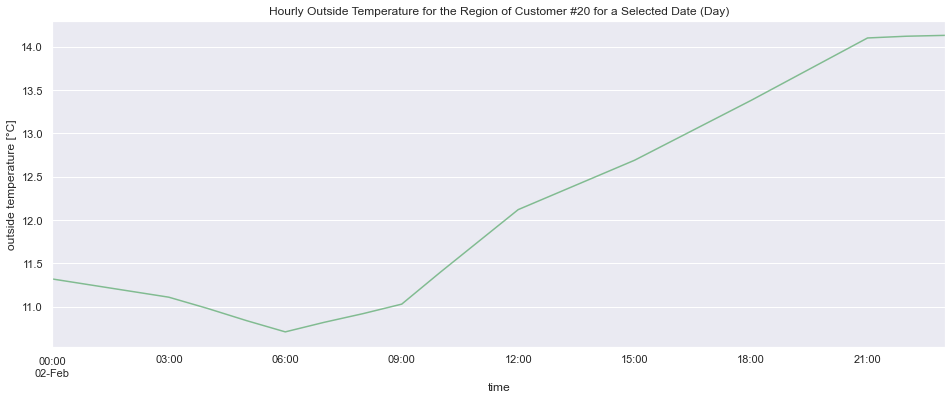

In [285]:
_ = weather.loc[date, customer].plot(title='Hourly Outside Temperature for the Region of Customer #' + \
                                   str(customer) + ' for a Selected Date (Day)',
                                  ylabel='outside temperature [°C]', color='g', alpha=0.7)

#### Day Category

The dataframe *days* contains all day-related properties like the *day of week* (0...6), the *day of month* (1...31), the *month* (1...12) within the year, and the *day category* (0: Monday, 1: Tuesday-Thursday, 2: Friday, 3: Saturday, 4: Sunday/Holiday). 

In [286]:
extractor.days

,day_of_week,day_of_month,month,day_category
date,,,,
2019-01-01,1,1,1,4
2019-01-02,2,2,1,1
2019-01-03,3,3,1,1
2019-01-04,4,4,1,2
2019-01-05,5,5,1,3
...,...,...,...,...
2019-12-27,4,27,12,2
2019-12-28,5,28,12,3
2019-12-29,6,29,12,4


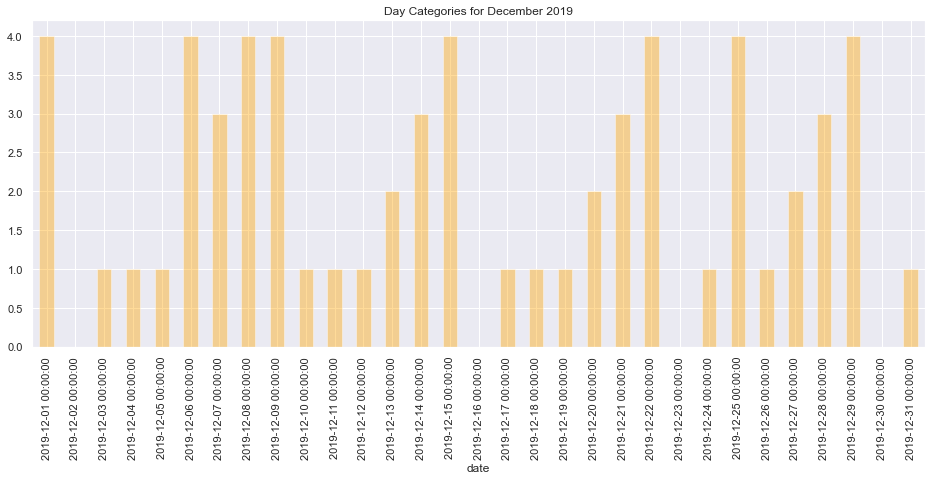

In [287]:
_ = extractor.days.loc['2019-12','day_category'].plot(kind='bar', color='orange', alpha=0.4,
                                                 title='Day Categories for December 2019')

### Feature and Target Vectors

The *features* contain three subsets: for training, test and validation. 

In [288]:
len(features)

3

The training data contain 80% of the total number of samples. The test and validation sets contain 10% each.

In [289]:
_ = [print(s + ': ' + str(len(f)) + ' samples') for f,s in zip(features, ['train', 'test', 'validate'])]

train: 88200 samples
test: 10850 samples
validate: 10850 samples


Each sample consists of 4 parts: the feature vector *Xa* and the target value *ya* for the submodel *A* (intraday prediction) and the feature vector *Xb* and the target value *yb* for the submodel *B* (day-ahead prediction).

In [290]:
len(features[0][0])

4

The feature vector *Xa* contains a total of **247** values: scaled hourly consumption values (7dx24h), scaled hourly temperature values (3dx24h), the month, the day of month and the onehot-encoded day category. The feature vector *Xb* contains a total of **35** values: scaled daily mean consumption values (14d), scaled daily mean temperature values (14d), the onehot-encoded day category, the day of month and the month.

The model *A* predicts the an abstract, unitless intraday curve with hourly resolution (24 values, target vector *ya*) and the model *B* predicts the day-ahead energy consumption (1 value, target vector *yb*).

In [291]:
_ = [print(s + ': ' + str(f.shape)) for f,s in zip(features[0][0], ['Xa', 'ya', 'Xb', 'yb'])]

Xa: (1, 247)
ya: (24,)
Xb: (1, 35)
yb: (1,)


In [292]:
features[0][0]

[array([[0.72717053, 0.72406324, 0.66293714, 0.51885418, 0.53268033,
         0.4999342 , 0.51084957, 0.51448803, 0.45408962, 1.06389527,
         1.39208422, 1.14976289, 1.10173524, 1.2625551 , 1.29602892,
         1.18978593, 1.14976289, 1.21088899, 1.25163973, 1.18541978,
         1.31785967, 1.41973651, 1.41318728, 1.38626269, 0.79173857,
         0.7044327 , 0.6999884 , 0.59628789, 0.59702861, 0.58221425,
         0.58591784, 0.56369631, 0.6999884 , 1.28219265, 1.50588945,
         1.21108373, 1.16960353, 1.27626691, 1.29552557, 1.25182322,
         1.20886158, 1.27848906, 1.01183062, 1.21256517, 1.18367717,
         1.10367964, 1.18515861, 1.10886466, 0.68517404, 0.68408186,
         0.51409041, 0.48206304, 0.50505705, 0.44839323, 0.48042061,
         0.4968449 , 0.58225123, 1.227726  , 1.38375679, 1.27946252,
         1.12835902, 1.23675936, 1.18995012, 1.07580127, 1.06676791,
         1.29013831, 1.11521958, 1.21212292, 1.33694755, 1.227726  ,
         1.24907758, 1.50283293, 1